In [2]:
import numpy as np

class DenseLayer:
    """
    Реализация слоя полносвязной нейронной сети
    """
    def __init__(self, input_size, output_size):
        """
        Конструктор класса, в котором инициализируются веса и смещения. 
        Веса инициализируются случайными значениями из стандартного нормального распределения, смещения инициализируются нулями. 
        input_size и output_size определяют количество нейронов на предыдущем и текущем слое соответственно.
        """
        self.input_size = input_size
        self.output_size = output_size
        self.weights = np.random.randn(output_size, input_size)
        self.bias = np.zeros((output_size, 1))
        self.input = None
        self.output = None
        self.gradient_weights = None
        self.gradient_bias = None

    def forward(self, input_data):
        """
        Прямой проход. Входные данные умножаются на веса, затем к результату добавляется смещение.
        """
        self.input = input_data
        self.output = np.dot(self.weights, input_data) + self.bias
        return self.output

    def backward(self, gradient):
        """
        Обратный проход. Сначала вычисляется градиент для весов и смещения.
        Далее вычисляется градиент по входным данным, который возвращается для последующей передачи по сети в обратном направлении.
        """
        self.gradient_weights = np.dot(gradient, self.input.T)
        self.gradient_bias = np.sum(gradient, axis=1, keepdims=True)
        return np.dot(self.weights.T, gradient)

    def update_parameters(self, learning_rate):
        """
        Обновление параметров. Веса и смещения уменьшаются на произведение соответствующего градиента и скорости обучения (learning rate).
        """
        self.weights -= learning_rate * self.gradient_weights
        self.bias -= learning_rate * self.gradient_bias

In [3]:
class SigmoidActivation:
    def __init__(self):
        self.input = None
        self.output = None

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def forward(self, input_data):
        self.input = input_data
        self.output = self.sigmoid(input_data)
        return self.output

    def backward(self, gradient):
        return gradient * self.output * (1 - self.output)


class NeuralNet:
    def __init__(self, layers, epochs=10, learning_rate=0.01, is_reg=False):
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.layers = layers
        self.is_reg = is_reg

    def forward(self, input_data):
        output = input_data
        for layer in self.layers:
            output = layer.forward(output)
        return output

    def backward(self, gradient):
        for layer in reversed(self.layers):
            gradient = layer.backward(gradient)

    def update_parameters(self, learning_rate):
        for layer in self.layers:
            if isinstance(layer, DenseLayer):
                layer.update_parameters(learning_rate)

    def one_hot_encode(self, labels, num_classes):
        encoded_labels = np.zeros((len(labels), num_classes))
        for i, label in enumerate(labels):
            encoded_labels[i, int(label)] = 1
        return encoded_labels

    def one_hot_decode(self, one_hot_array):
        return np.argmax(one_hot_array, axis=1)

    def fit(self, X, y):
        if not self.is_reg:
            num_classes = len(np.unique(y))
            y_encoded = self.one_hot_encode(y, num_classes)
        else:
            y_encoded = y.reshape(-1, 1)
        for epoch in range(self.epochs):
            total_loss = 0
            for i in range(X.shape[0]):
                # Forward pass
                input_data = (X[i, :].reshape(-1, 1) if len(X.shape) > 1 else np.array([[X[i]]]))
                target = y_encoded[i, :].reshape(-1, 1)

                output = self.forward(input_data)

                # Compute loss (using mean squared error)
                loss = np.mean((output - target) ** 2)
                total_loss += loss

                # Backward pass (gradient computation)
                gradient = 2 * (output - target)  # derivative of mean squared error
                self.backward(gradient)

                # Update parameters
                self.update_parameters(self.learning_rate)

            # Print average loss for the epoch
            if (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch + 1}/{self.epochs}, Loss: {total_loss / X.shape[0]}"                )

    def predict(self, X):
        predictions = []
        for i in range(X.shape[0]):
            input_data = (X[i, :].reshape(-1, 1) if len(X.shape) > 1 else np.array([[X[i]]]))
            output = self.forward(input_data)
            predictions.append(output.flatten())
        if self.is_reg:
            return np.array(predictions)
        return self.one_hot_decode(np.array(predictions))

In [4]:
class KNN:
    def __init__(self, K=3):
        self.K = K
        
    def fit(self, x_train, y_train = None):
            self.X_train = x_train
            self.Y_train = y_train

    def predict(self, X_test):
        predictions = [] 
        dists = np.linalg.norm(self.X_train[:, None] - X_test, axis=2).T
        for dist in dists:
            dist_sorted_indices = np.argsort(dist)[:self.K]
            
            # Считаем, сколько раз каждая метка встречается среди ближайших соседей
            unique_labels, neighbor_counts = np.unique(self.Y_train[dist_sorted_indices], return_counts=True)
            
            # Находим метку, которая встречается наибольшее количество раз
            predicted_label = unique_labels[np.argmax(neighbor_counts)]
            
            predictions.append(predicted_label)
        return np.array(predictions)

In [5]:
def test_model(model, x_train, y_train, x_test, y_test):
    model.fit(x_train, y_train)
    pred = model.predict(x_test)
    acc = (pred == y_test).mean()
    return acc

In [6]:
from sklearn.datasets import load_digits
mnist = load_digits()

X = mnist.data 
y = mnist.target

test_size = 0.25

num_samples = len(X)
num_test_samples = int(test_size * num_samples)
test_indices = np.random.choice(num_samples, num_test_samples, replace=False)

X_train = X[np.logical_not(np.isin(np.arange(num_samples), test_indices))]
y_train = y[np.logical_not(np.isin(np.arange(num_samples), test_indices))]
X_test = X[test_indices]
y_test = y[test_indices]

input_size = X_train[0].size
hidden_size = 100
output_size = y_train.max() + 1

nn_model = NeuralNet(
    [
        DenseLayer(input_size, hidden_size),
        SigmoidActivation(),
        DenseLayer(hidden_size, output_size),
        SigmoidActivation(),
    ],
    epochs=500,
    learning_rate=0.1,
)

knn_model = KNN(3)

print(f"NN accuracy: {test_model(nn_model, X_train, y_train, X_test, y_test)}")
print(f"KNN accuracy: {test_model(knn_model, X_train, y_train, X_test, y_test)}")

Epoch 10/500, Loss: 0.02236477688711958
Epoch 20/500, Loss: 0.019374040047510765
Epoch 30/500, Loss: 0.019612345013243822
Epoch 40/500, Loss: 0.01731876786793446
Epoch 50/500, Loss: 0.017417086052892383
Epoch 60/500, Loss: 0.014954330451137464
Epoch 70/500, Loss: 0.015327979894431657
Epoch 80/500, Loss: 0.014303827773398295
Epoch 90/500, Loss: 0.012893429596921864
Epoch 100/500, Loss: 0.01386880422178958
Epoch 110/500, Loss: 0.014185405642704589
Epoch 120/500, Loss: 0.01476786476082671
Epoch 130/500, Loss: 0.015209931672493484
Epoch 140/500, Loss: 0.014345747659588574
Epoch 150/500, Loss: 0.013211803576681003
Epoch 160/500, Loss: 0.014660261021903704
Epoch 170/500, Loss: 0.011643776594020468
Epoch 180/500, Loss: 0.011399731946865638
Epoch 190/500, Loss: 0.011084871966119337
Epoch 200/500, Loss: 0.01142037566870509
Epoch 210/500, Loss: 0.01086186074781843
Epoch 220/500, Loss: 0.010667347541216336
Epoch 230/500, Loss: 0.010618756522607485
Epoch 240/500, Loss: 0.010574878012945517
Epoch 2

In [7]:
# Определение функций для аппроксимации
def func1(x):
    return np.cos(2 * np.pi * x)

def func2(x):
    return 5 * x**3 + x**2 + 5

def func3(x):
    return x * np.sin(2 * np.pi * x)


# Функция для создания выборки с заданной функцией и ошибками измерения
def generate_data(func, error_type="uniform", scale=0.1):
    x = np.linspace(0, 2 * np.pi, 100)
    if error_type == "uniform":
        error = np.random.uniform(-scale, scale, len(x))
    else:
        error = np.random.normal(0, scale, len(x))
    y = func(x) + error
    return x, y

In [8]:
def find_best_model(models, x, y, folds=5):
    best_mse = float("inf")
    best_model = None
    fold_size = len(y) // folds
    for model in models:
        mse_sum = 0
        for i in range(folds):
            test_start = i * fold_size
            test_end = test_start + fold_size
            x_test = x[test_start:test_end]
            y_test = y[test_start:test_end]
            x_train = np.concatenate((x[:test_start], x[test_end:]))
            y_train = np.concatenate((y[:test_start], y[test_end:]))

            model.fit(x_train, y_train)
            y_pred = model.predict(x_test)

            mse = np.mean((y_pred - y_test) ** 2)
            mse_sum += mse

        avg_mse = mse_sum / folds

        if avg_mse < best_mse:
            best_model = model
            best_mse = avg_mse

    return best_model

Epoch 10/200, Loss: 0.10210837484746628
Epoch 20/200, Loss: 0.10198666647534846
Epoch 30/200, Loss: 0.10188687791947454
Epoch 40/200, Loss: 0.10180093234247453
Epoch 50/200, Loss: 0.10172326607668282
Epoch 60/200, Loss: 0.10165069614883633
Epoch 70/200, Loss: 0.10158142627725031
Epoch 80/200, Loss: 0.10151441427080404
Epoch 90/200, Loss: 0.10144901421249262
Epoch 100/200, Loss: 0.10138479311096062
Epoch 110/200, Loss: 0.10132144396101393
Epoch 120/200, Loss: 0.10125874491748933
Epoch 130/200, Loss: 0.10119653779023528
Epoch 140/200, Loss: 0.10113471428995022
Epoch 150/200, Loss: 0.10107320598896871
Epoch 160/200, Loss: 0.10101197673507124
Epoch 170/200, Loss: 0.10095101694656636
Epoch 180/200, Loss: 0.10089033930508419
Epoch 190/200, Loss: 0.10082997539414479
Epoch 200/200, Loss: 0.10076997291128546
Epoch 10/200, Loss: 0.11092422681330476
Epoch 20/200, Loss: 0.1108110677467022
Epoch 30/200, Loss: 0.11075225415673369
Epoch 40/200, Loss: 0.11071907183818955
Epoch 50/200, Loss: 0.11069863

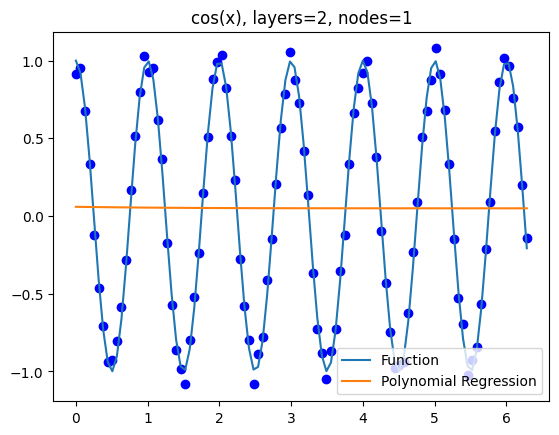

For func: cos(x), Best numlayers: 2, Best num hidden nodes: 1
Epoch 10/200, Loss: 0.06598153542646297
Epoch 20/200, Loss: 0.06595659678208865
Epoch 30/200, Loss: 0.06593315753784308
Epoch 40/200, Loss: 0.06591471176562232
Epoch 50/200, Loss: 0.0658998288097954
Epoch 60/200, Loss: 0.06588757074324653
Epoch 70/200, Loss: 0.06587730158625002
Epoch 80/200, Loss: 0.06586857504244882
Epoch 90/200, Loss: 0.06586106879093592
Epoch 100/200, Loss: 0.06585454429290652
Epoch 110/200, Loss: 0.06584882126675858
Epoch 120/200, Loss: 0.06584376094947574
Epoch 130/200, Loss: 0.0658392548100266
Epoch 140/200, Loss: 0.06583521675128096
Epoch 150/200, Loss: 0.06583157760505177
Epoch 160/200, Loss: 0.06582828117087687
Epoch 170/200, Loss: 0.0658252813163878
Epoch 180/200, Loss: 0.0658225398217669
Epoch 190/200, Loss: 0.06582002475480841
Epoch 200/200, Loss: 0.06581770923030705
Epoch 10/200, Loss: 0.006098585176713351
Epoch 20/200, Loss: 0.00297006004716858
Epoch 30/200, Loss: 0.00220485256492264
Epoch 40/2

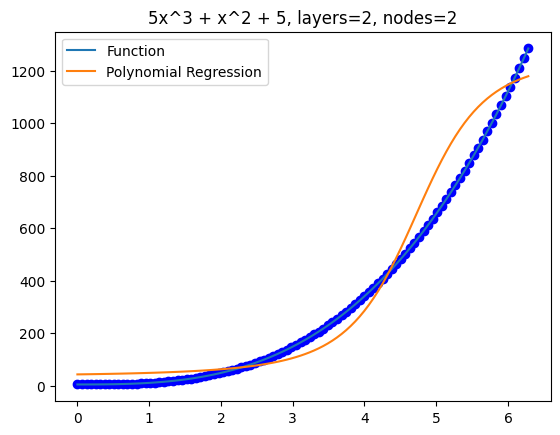

For func: 5x^3 + x^2 + 5, Best numlayers: 2, Best num hidden nodes: 2
Epoch 10/200, Loss: 0.08783274519566446
Epoch 20/200, Loss: 0.08782719340990748
Epoch 30/200, Loss: 0.08782350512495665
Epoch 40/200, Loss: 0.08782111557592337
Epoch 50/200, Loss: 0.08781961984173653
Epoch 60/200, Loss: 0.08781874720703564
Epoch 70/200, Loss: 0.08781831338539478
Epoch 80/200, Loss: 0.0878181908432712
Epoch 90/200, Loss: 0.08781829001019453
Epoch 100/200, Loss: 0.08781854715216658
Epoch 110/200, Loss: 0.08781891640035845
Epoch 120/200, Loss: 0.087819364419808
Epoch 130/200, Loss: 0.08781986678580353
Epoch 140/200, Loss: 0.08782040548388055
Epoch 150/200, Loss: 0.0878209671610683
Epoch 160/200, Loss: 0.08782154188700174
Epoch 170/200, Loss: 0.08782212226593637
Epoch 180/200, Loss: 0.0878227027934161
Epoch 190/200, Loss: 0.08782327938558535
Epoch 200/200, Loss: 0.08782384903170104
Epoch 10/200, Loss: 0.010976647477972702
Epoch 20/200, Loss: 0.010970067002171523
Epoch 30/200, Loss: 0.01096430404641525
Ep

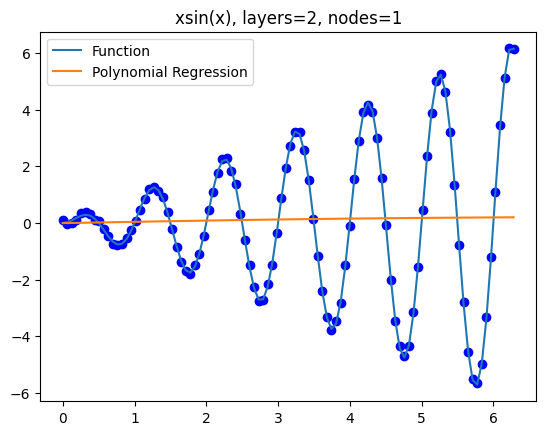

For func: xsin(x), Best numlayers: 2, Best num hidden nodes: 1


In [11]:
import matplotlib.pyplot as plt


def get_model(num_hidden_layers, num_hidden_nodes):
    layers = [
        DenseLayer(1, num_hidden_nodes),
        SigmoidActivation(),
    ]
    for _ in range(num_hidden_layers - 1):
        layers.append(DenseLayer(num_hidden_nodes, num_hidden_nodes))
        layers.append(SigmoidActivation())
    layers.append(DenseLayer(num_hidden_nodes, 1))
    layers.append(SigmoidActivation())
    model = NeuralNet(layers, 200, 0.1, True)
    return model


def get_num_hidden_layers(model):
    return (len(model.layers) - 1) // 2


def get_num_hidden_nodes(model):
    return model.layers[0].output_size


# Зададим значения параметра M
num_hidden_layers_values = [1, 2]
num_hidden_nodes_values = [1, 2, 3]

for func, func_name in [
    (
        func1,
        "cos(x)",
    ),  # For func: cos(x), Best numlayers: 2, Best num hidden nodes: 1
    (
        func2,
        "5x^3 + x^2 + 5",
    ),  # For func: 5x^3 + x^2 + 5, Best numlayers: 1, Best num hidden nodes: 1
    (
        func3,
        "xsin(x)",
    ),  # For func: xsin(x), Best numlayers: 2, Best num hidden nodes: 3
]:
    models = np.array(
        [
            [get_model(layers, nodes) for nodes in num_hidden_nodes_values]
            for layers in num_hidden_layers_values
        ]
    ).reshape(-1)
    x, y = generate_data(func)
    min_val = np.min(y)
    max_val = np.max(y)
    y_norm = (y - min_val) / (max_val - min_val)
    model = find_best_model(models, x, y_norm, 2)
    model.fit(x, y_norm)
    y_pred_norm = model.predict(x)
    y_pred = y_pred_norm * (max_val - min_val) + min_val
    best_num_hidden_layers = get_num_hidden_layers(model)
    best_num_hidden_nodes = get_num_hidden_nodes(model)

    plt.figure()
    plt.plot(x, y, "bo")
    plt.plot(x, func(x), label="Function")
    plt.plot(x, y_pred, label="Polynomial Regression")
    plt.title(f"{func_name}, layers={best_num_hidden_layers}, nodes={best_num_hidden_nodes}")
    plt.legend()
    plt.show()

    print(
        f"For func: {func_name}, Best numlayers: {best_num_hidden_layers}, Best num hidden nodes: {best_num_hidden_nodes}"
    )